In [2]:
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

데이터 불러오기

In [3]:
data_path= "data"
normal_files = glob.glob(data_path+'/normal/'+'*.csv')
anormal_drift_files = glob.glob(data_path+'/anormal_drift/'+'*.csv')
anormal_erratic_files = glob.glob(data_path+'/anormal_erratic/'+'*.csv')
anormal_hardover_files = glob.glob(data_path+'/anormal_hardover/'+'*.csv')
anormal_spike_files = glob.glob(data_path+'/anormal_spike/'+'*.csv')
anormal_stuck_files = glob.glob(data_path+'/anormal_stuck/'+'*.csv')

In [4]:
#print(normal_files)

In [5]:
def dataReader(path_names):
    data_n = pd.DataFrame() #판다스의 데이터프레임 형태로 프레임 생성
    for i in path_names:
        low_data = pd.read_csv(i)# 판다스 형태로 읽음, 한csv파일씩 읽기 떄문에 다음 라인에서 하나로 합침
        data_n = pd.concat([data_n,low_data],ignore_index=True)
    return data_n

In [6]:
normal_datas = dataReader(normal_files)
drift_datas = dataReader(anormal_drift_files)
erratic_datas = dataReader(anormal_erratic_files)
hardover_datas = dataReader(anormal_hardover_files)
spike_datas = dataReader(anormal_spike_files)
stuck_datas = dataReader(anormal_stuck_files)

data shape 변경

In [7]:
#LSTM, LSTM-AE
def X_to_XyLSTM_shape(X,ntime_in,ntime_out): #X변형할 시계열 데이터 n_time_in 만큼 하나의 input으로 봄, ntime_out만큼 뒤에꺼를 예측
    nsample = len(X) - ntime_in -ntime_out + 1
    X_ntime = [0 for _ in range(nsample)]
    for i in range(nsample):
        X_ntime[i] = X[i:i+ntime_in]
    X_train = np.reshape(X_ntime,(nsample,ntime_in,1)) #2차원 배열을 3차원 배열으로
    #print('X',X_train.shape)
    y_nfuture = [0 for _ in range(nsample)]
    for i in range(nsample):
        y_nfuture[i] = X[i+ntime_in:i+ntime_in+ntime_out]
    y_train = np.array(y_nfuture)
    #print('y',y_train.shape)
    return X_train,y_train

In [8]:
n_time_in = 10 # 10개의 데이터 입력으로 받음
ntime_out = 1 # 다음 한개의 데이터 목표값

X_LSTM_train, y_LSTM_train = X_to_XyLSTM_shape(normal_datas['value'],n_time_in,ntime_out)

In [9]:
#AE
def X_to_XyAE_shape(X,ntime_out): #X변형할 시계열 데이터, ntime_out만큼 뒤에꺼를 예측
    nsample = len(X) - ntime_out
    X_train = np.array(X[:nsample])
    y_train = np.array(X[ntime_out:len(X)])
    #print('X',X_train.shape)
    #print('y',y_train.shape)
    return X_train,y_train

In [10]:
X_AE_train, y_AE_train = X_to_XyAE_shape(normal_datas['value'],1)

모델 생성

In [11]:
from tensorflow.python.keras.layers import InputLayer, Dense, LSTM
from tensorflow.python.keras.models import Sequential

#LSTM_AE 모델
LSTM_AE_model = Sequential()

LSTM_AE_model.add(LSTM(128, input_shape=(n_time_in, 1)))
LSTM_AE_model.add(Dense(64, activation='relu',kernel_initializer='random_uniform'))
LSTM_AE_model.add(Dense(32, activation='relu',kernel_initializer='random_uniform'))
LSTM_AE_model.add(Dense(64, activation='relu',kernel_initializer='random_uniform'))
LSTM_AE_model.add(Dense(128, activation='relu',kernel_initializer='random_uniform'))
LSTM_AE_model.add(Dense(ntime_out))

LSTM_AE_model.compile(loss="mean_squared_error",optimizer='adam')

#LSTM 모델
LSTM_model = Sequential()

LSTM_model.add(LSTM(128, input_shape=(n_time_in, 1)))
LSTM_model.add(Dense(ntime_out))

LSTM_model.compile(loss="mean_squared_error",optimizer='adam')

#AE 모델
"""
input_dim = 1  # 시계열 데이터의 차원
seq_length = 10  # 시계열 데이터의 길이
AE_model = Sequential()

AE_model.add(InputLayer(input_shape=(1,input_dim)))
AE_model.add(Dense(128, activation='relu',kernel_initializer='random_uniform'))
AE_model.add(Dense(64, activation='relu',kernel_initializer='random_uniform'))
AE_model.add(Dense(32, activation='relu',kernel_initializer='random_uniform'))
AE_model.add(Dense(64, activation='relu',kernel_initializer='random_uniform'))
AE_model.add(Dense(128, activation='relu',kernel_initializer='random_uniform'))
AE_model.add(Dense(input_dim,activation='linear'))

AE_model.compile(loss="mean_squared_error",optimizer='adam')
"""

AE_model = Sequential()

AE_model.add(InputLayer(input_shape=(1,1)))
AE_model.add(Dense(128, activation='relu',kernel_initializer='random_uniform'))
AE_model.add(Dense(64, activation='relu',kernel_initializer='random_uniform'))
AE_model.add(Dense(32, activation='relu',kernel_initializer='random_uniform'))
AE_model.add(Dense(64, activation='relu',kernel_initializer='random_uniform'))
AE_model.add(Dense(128, activation='relu',kernel_initializer='random_uniform'))
AE_model.add(Dense(ntime_out,activation='linear'))

AE_model.compile(loss="mean_squared_error",optimizer='adam')

학습

In [12]:
LSTM_AE_model.fit(X_LSTM_train, y_LSTM_train, epochs=1, batch_size=100, verbose=0)

In [13]:
LSTM_model.fit(X_LSTM_train,y_LSTM_train, epochs=1, batch_size=100, verbose=0)

In [14]:
AE_model.fit(X_AE_train,y_AE_train, epochs=1, batch_size=100, verbose=0)

Test

In [15]:
def MSE(target,predict):
    return (1.0/2.0)*(target-predict)**2

In [16]:
def error_matrix(perdict_error,real_error,threshold):
    predict_size = len(perdict_error)
    #오차행렬 초기화
    tp = 0
    fp = 0
    tn = 0
    fn = 0 
    Accuracy = np.nan
    Recall = np.nan
    Percision = np.nan
    Specificity = np.nan
    for i in range(predict_size):
        modelP = 0
        modelN = 0
        trueP = 0
        trueN = 0
        # 모델에 대한 P,N
        if(perdict_error[i] > threshold):
            modelP = 1
        else:
            modelN = 1
        #실제값에 대한 P,N
        if(real_error[i] == 1):
            trueP = 1
        else:
            trueN = 1
        #오차 행렬 업데이트
        if(modelP==1 and trueP == 1):
            tp += 1
        elif(modelP == 1 and trueN == 1):
            fp += 1
        elif(modelN == 1 and trueN == 1):
            tn += 1
        elif(modelN == 1 and trueP == 1):
            fn += 1
    if(tp+tn+fp+fn != 0):
        Accuracy = float(tp+tn)/float(tp+tn+fp+fn) # 전체 예측 중 맞게 예측
    if(tp+fn != 0):
        Recall = float(tp)/float(tp+fn) # 실제 오류 중 오류라고 예측한 것
    if(tp+fp != 0):
        Percision = float(tp)/float(tp+fp) # 오류라고 예측한 것 중 실제 오류
    if(fp+tn != 0):
        Specificity = float(tn)/float(fp+tn) # 오류가 아니라고 예측 한 것 중 정말 오류가 아닌 것
    
    return Accuracy,Recall,Percision,Specificity

In [17]:
def evaluation(y_test,y_predict,test_size,test_data,threshold):
    perdict_error =MSE(y_test[:test_size-ntime_out],y_predict[ntime_out:test_size])
    perdict_error = perdict_error.reshape(len(perdict_error))
    perdict_error.shape

    real_error = np.array(test_data['error'][n_time_in:test_size+n_time_in-ntime_out])
    real_error.shape

    Accuracy,Recall,Percision,Specificity = error_matrix(perdict_error,real_error,threshold)
    #print(error_matrix(perdict_error,real_error,threshold))
    round2 = lambda number: round(number, 2)
    
    return np.column_stack((round2(Accuracy*100),round2(Recall*100),round2(Percision*100),round2(Specificity*100))) #%로 바꾸고 소수점 2자리까지 표현

In [18]:
def LSTM_AE_evaluate(test_data,threshold):
    #print("------------LSTM-AE---------------")
    X_LSTMAE_test,y_LSTMAE_test =X_to_XyLSTM_shape(test_data['value'][:10000],n_time_in,ntime_out)
    y_LSTMAE_predict = LSTM_AE_model.predict(X_LSTMAE_test,verbose=0)
    test_size = len(y_LSTMAE_predict)

    """
    plt.plot(MSE(y_LSTMAE_test[:test_size-ntime_out],y_LSTMAE_predict[ntime_out:test_size])) #y_test는 실제 값 ,y_predict는 예측 값 예측값은 ntime_out 만큼 밀려서 나옴
    #plt.plot(y_LSTMAE_test[:test_size-ntime_out]-y_LSTMAE_predict[ntime_out:test_size])
    plt.plot(test_data['error'][n_time_in:test_size+n_time_in-ntime_out])
    #plt.plot(test_data['value'][n_time_in:test_size]) # test_data['value'][n_time_in:test_size] == y_test[:test_size-ntime_out] 실제 값
    plt.show()
    plt.close()
    """
    #print(evaluation(y_LSTMAE_test,y_LSTMAE_predict,test_size,test_data,threshold))
    return evaluation(y_LSTMAE_test,y_LSTMAE_predict,test_size,test_data,threshold)
    
    
    
def LSTM_evaluate(test_data,threshold):
    #print("--------------LSTM-----------------")
    X_LSTM_test,y_LSTM_test = X_to_XyLSTM_shape(test_data['value'][:10000],n_time_in,ntime_out)
    y_LSTM_predict = LSTM_model.predict(X_LSTM_test,verbose=0)
    test_size = len(y_LSTM_predict)
    """
    plt.plot(MSE(y_LSTM_test[:test_size-ntime_out],y_LSTM_predict[ntime_out:test_size])) #y_test는 실제 값 ,y_predict는 예측 값 예측값은 ntime_out 만큼 밀려서 나옴
    #plt.plot(y_LSTMAE_test[:test_size-ntime_out]-y_LSTMAE_predict[ntime_out:test_size])
    plt.plot(test_data['error'][n_time_in:test_size+n_time_in-ntime_out])
    #plt.plot(test_data['value'][n_time_in:test_size]) # test_data['value'][n_time_in:test_size] == y_test[:test_size-ntime_out] 실제 값
    plt.show()
    plt.close()
    """
    #print(evaluation(y_LSTM_test,y_LSTM_predict,test_size,test_data,threshold))
    return evaluation(y_LSTM_test,y_LSTM_predict,test_size,test_data,threshold)

def AE_evaluate(test_data,threshold):
    #print("----------------AE------------------")
    X_AE_test,y_AE_test = X_to_XyAE_shape(test_data['value'][:10000],ntime_out)
    y_AE_predict = AE_model.predict(X_AE_test,verbose=0)
    y_AE_predict = y_AE_predict.reshape(len(y_AE_predict))
    test_size = len(y_AE_predict)

    """
    plt.plot(MSE(y_AE_test[:test_size-ntime_out],y_AE_predict[ntime_out:test_size])) #y_test는 실제 값 ,y_predict는 예측 값 예측값은 ntime_out 만큼 밀려서 나옴
    #plt.plot(y_LSTMAE_test[:test_size-ntime_out]-y_LSTMAE_predict[ntime_out:test_size])
    plt.plot(test_data['error'][n_time_in:test_size+n_time_in-ntime_out])
    #plt.plot(test_data['value'][n_time_in:test_size]) # test_data['value'][n_time_in:test_size] == y_test[:test_size-ntime_out] 실제 값
    plt.show()
    plt.close()
    """
    #print(evaluation(y_AE_test,y_AE_predict,test_size,test_data,threshold))
    return evaluation(y_AE_test,y_AE_predict,test_size,test_data,threshold)

In [19]:
anormal_list = [('drift',drift_datas),('erratic',erratic_datas),('hardover',hardover_datas),('spike',spike_datas),('stuck',stuck_datas)]

In [20]:
for anormal_type in anormal_list: #anormal_type[0]는 이름 anormal_type[1]는 판다스 데이터
    LSTM_AE_list = []
    LSTM_list = []
    AE_list = []
    if (anormal_type[0] == 'drift'):
        threshold = np.arange(4, 15, 0.5)
    """ ##################### 수정 #########################
    if (anormal_type[0] == "erratic"):
        threshold = np.arange(7, 10, 0.5)
    if (anormal_type[0] == "hardover"):
        threshold = np.arange(7, 10, 0.5)
    if (anormal_type[0] == "spike"):
        threshold = np.arange(7, 10, 0.5)
    if (anormal_type[0] == "stuck"):
        threshold = np.arange(7, 10, 0.5)
    """
    for i in threshold:
        #LSTM_AE 
        LSTM_AE_evaluation = LSTM_AE_evaluate(anormal_type[1],i)
        LSTM_AE_evaluation = np.append(LSTM_AE_evaluation,i)
        LSTM_AE_list.append(LSTM_AE_evaluation)
        #LSTM
        LSTM_evaluation = LSTM_evaluate(anormal_type[1],i)
        LSTM_evaluation = np.append(LSTM_evaluation,i)
        LSTM_list.append(LSTM_evaluation)
        #AE
        AE_evaluation = AE_evaluate(anormal_type[1],i)
        AE_evaluation = np.append(AE_evaluation,i)
        AE_list.append(AE_evaluation)
   
    LSTM_AE_np = np.array(LSTM_AE_list)
    LSTM_np = np.array(LSTM_list)
    AE_np = np.array(AE_list)
    print("LSTM_AE_np")
    print(LSTM_AE_np)
    print("LSTM_np")
    print(LSTM_np)
    print("AE_np")
    print(AE_np)

    header="Accuracy,Recall,Percision,Specificity,Threshold"
    np.savetxt(f"model_evaluation/LSTM_AE/{anormal_type[0]}.csv",LSTM_AE_np,delimiter=',',header=header, comments='')
    np.savetxt(f"model_evaluation/LSTM/{anormal_type[0]}.csv",LSTM_np,delimiter=',',header=header, comments='')
    np.savetxt(f"model_evaluation/AE/{anormal_type[0]}.csv",AE_np,delimiter=',',header=header, comments='')
    #
    #AE_evaluate(anormal_type[1],8.5)
    ######################################LSTM_AE 만 완성#####################

LSTM_AE_np
[[81.78 94.91 56.18 77.85  4.  ]
 [83.73 94.65 59.17 80.47  4.5 ]
 [85.58 94.3  62.36 82.98  5.  ]
 [87.27 94.   65.59 85.25  5.5 ]
 [88.56 93.78 68.32 86.99  6.  ]
 [89.92 93.52 71.49 88.84  6.5 ]
 [90.79 93.22 73.73 90.06  7.  ]
 [91.63 93.09 75.98 91.2   7.5 ]
 [92.29 92.83 77.92 92.13  8.  ]
 [92.92 92.61 79.87 93.02  8.5 ]
 [93.44 92.26 81.65 93.8   9.  ]
 [93.92 92.13 83.26 94.46  9.5 ]
 [94.38 92.   84.88 95.1  10.  ]
 [94.8  91.91 86.39 95.67 10.5 ]
 [95.07 91.74 87.48 96.07 11.  ]
 [95.43 91.57 88.94 96.59 11.5 ]
 [95.62 91.35 89.79 96.89 12.  ]
 [95.76 91.3  90.36 97.09 12.5 ]
 [95.91 91.17 91.06 97.32 13.  ]
 [96.13 91.09 92.01 97.63 13.5 ]
 [96.32 91.   92.86 97.91 14.  ]
 [96.51 90.83 93.8  98.21 14.5 ]]
LSTM_np
[[85.15 94.61 61.56 82.33  4.  ]
 [86.93 94.39 64.84 84.69  4.5 ]
 [88.58 94.3  68.23 86.86  5.  ]
 [89.87 93.87 71.25 88.67  5.5 ]
 [90.99 93.57 74.1  90.22  6.  ]
 [91.77 93.3  76.26 91.31  6.5 ]
 [92.67 93.13 78.87 92.53  7.  ]
 [93.47 93.09 81.28 93.

In [21]:
def evaluation_file_to_pd(model):
    drift_files = glob.glob(f'model_evaluation/{model}/drift.csv')
    erratic_files = glob.glob(f'model_evaluation/{model}/erratic.csv')
    hardover_files = glob.glob(f'model_evaluation/{model}/hardover.csv')
    spike_files = glob.glob(f'model_evaluation/{model}/spike.csv')
    stuck_files = glob.glob(f'model_evaluation/{model}/stuck.csv')

    drift_datas = dataReader(drift_files)
    erratic_datas = dataReader(erratic_files)
    hardover_datas = dataReader(hardover_files)
    spike_datas = dataReader(spike_files)
    stuck_datas = dataReader(stuck_files)

    return drift_datas,erratic_datas,hardover_datas,spike_datas,stuck_datas

In [22]:
model_list = ['AE','LSTM','LSTM_AE']
for model in model_list:
    drift_datas,erratic_datas,hardover_datas,spike_datas,stuck_datas = evaluation_file_to_pd(model) #'AE','LSTM','LSTM_AE'
    #print(model)
    #print(drift_datas)

drift_datas
AE 6.0


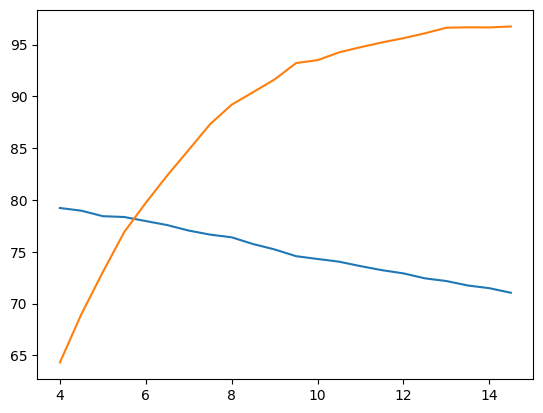

drift_datas
LSTM 11.5


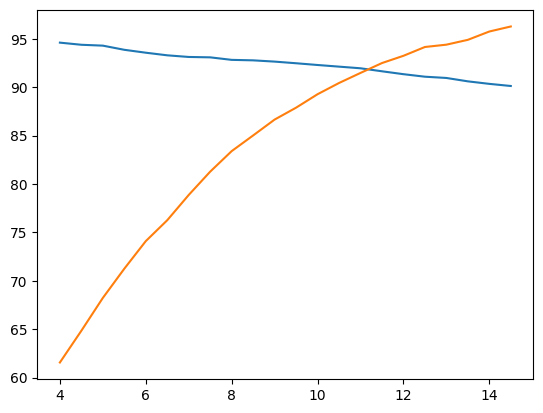

drift_datas
LSTM_AE 13.5


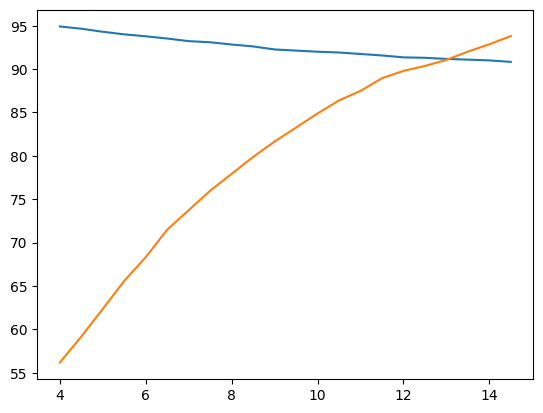

In [24]:
model_list = ['AE','LSTM','LSTM_AE']
for model in model_list:
    drift_datas,erratic_datas,hardover_datas,spike_datas,stuck_datas = evaluation_file_to_pd(model) #'AE','LSTM','LSTM_AE'
    file_size = len(drift_datas)
    for i in range(file_size):
        #print(drift_datas["Recall"][i],drift_datas["Percision"][i])
        if(drift_datas["Recall"][i]<=drift_datas["Percision"][i]):
            print("drift_datas")
            print(model,drift_datas["Threshold"][i])
            break
    plt.plot(drift_datas["Threshold"],drift_datas["Recall"])
    plt.plot(drift_datas["Threshold"],drift_datas["Percision"])
    plt.show()
        